In [1]:
using local_POD_overlap.module_2D

using LinearAlgebra
using Plots
using LaTeXStrings
using ProgressBars

import LinearAlgebra.eigvals 
using Statistics
using Random
using Distributions

┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   Base.PkgId(Base.UUID("082447d4-558c-5d27-93f4-14fc19e9eca2"), "ChainRules")
│   Base.PkgId(Base.UUID("1285c0f1-ff9f-5867-b66e-0f359bcf09ba"), "SpecialFunctionsExt")
│   Base.PkgId(Base.UUID("0c68f7d7-f131-5f86-a1c3-88cf8149b2d7"), "GPUArrays")
│   Base.PkgId(Base.UUID("a1ab010e-6f71-51d6-acc8-fb8bfa4c0f92"), "FluxCUDAcuDNNExt")
│   Base.PkgId(Base.UUID("63c18a36-062a-441e-b654-da1e3ab1ce7c"), "KernelAbstractions")
│   Base.PkgId(Base.UUID("dd41ee52-2073-581e-92e8-26baf003f19a"), "FluxCUDAExt")
│   Base.PkgId(Base.UUID("0b1bfda6-eb8a-41d2-88d8-f5af5cad476f"), "OneHotArrays")
│   Base.PkgId(Base.UUID("338a49bd-c049-5b4c-976b-5ff9d2bfb7e7"), "MLDataDevicesOneHotArraysExt")
│   Base.PkgId(Base.UUID("b7a43d79-68b1-555e-8052-5fba48570bb1"), "MLDataDevicesGPUArraysExt")
│   Base.PkgId(Base.UUID("02a925ec-e4fe-4b08-9a7e-0d78e3d38ccd"), "cuDNN")
│   Base.PkgId(Base.UUID("c8a29c40-e0ac-5e6e-8984-8da3115ac879"), "NNl

### 

# Code plan

## - Code energy-preserving discretization
## - Randomly generate turbulent velocity fields
## - Do a pressure projection on the velocity fields
## - Run the simulation 
## - Implement local POD with overlap
## - Implement projection
## - Test POD approaches

In [2]:
N = (200,200)
UPC = 1       


x= collect(LinRange(0,1,N[1]+1))
y = collect(LinRange(0,1,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)

# number of unknowns per cell

J = (10,10) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0



┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = ConvTranspose((10, 10), 1 => 1, stride=10, bias=false)  # 100 parameters
│   summary(x) = "20×20×1×1 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/3711C/src/layers/stateless.jl:60


0

In [3]:
#gen_setup(fine_mesh)

#test_q = random(Uniform(0,1),(fine_mesh.N...,1,5))

In [4]:
eta(x) = exp.(-(x)/(x*(1-x)))

eta (generic function with 1 method)

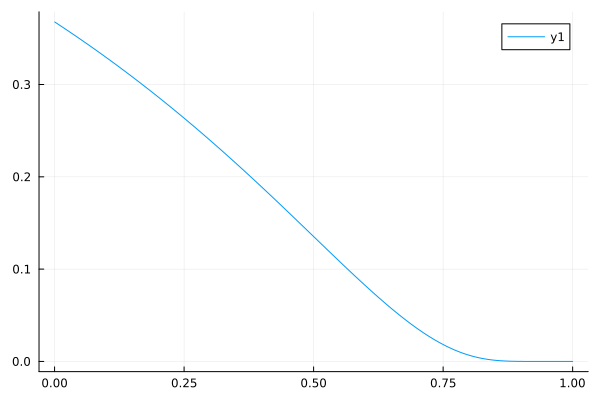

In [5]:
plot(collect(LinRange(0,1,3000)),eta.( collect(LinRange(0,1,3000))))

In [6]:
function f1(x)

    return (1 .- x[1]) .* (1 .- x[2])
end

function f2(x)

    return (x[1]) .* (1 .- x[2])
end
function f3(x)

    return x[1] .* x[2]
end
function f4(x)

    return (1 .- x[1]) .* x[2]
end


function bilinear_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)

    
    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    

    

    

    f1 = (x1 ) .* (y1)
    f2 = (1 .- x2 ) .* ( y2 )
    f3 = (x3 ) .* (1 .- y3  )
    f4 = (1 .- x4) .* (1 .- y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end


function mollifier_bump_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)


    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    delta = 1e-10
    ## circumvent the NaN at x = 0
    x1,y1 = max.(x1,delta), max.(y1,delta)
    x2,y2 = max.(x2,delta), max.(y2,delta)
    x3,y3 = max.(x3,delta), max.(y3,delta)
    x4,y4 = max.(x4,delta), max.(y4,delta)

    
    eta(x) = exp.(-(x)/(x*(1-x)))

    eta_tilde(x) = eta(x)/(eta(x)+eta(1-x))
    a(x) = eta_tilde(x)
    b(x) = 1 -a(x)
    
    f1 = b.(x1) .* b.(y1)
    f2 = a.(x2) .* b.(y2)
    f3 = b.(x3) .* a.(y3)
    f4 = a.(x4) .* a.(y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end

function sinusodal_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)


    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    
    o1 = 0 .* x1
    o2 = 0 .* x2
    o3 = 0 .* x3

    
    d4 = sqrt.(x4.^2 .+ y4.^2)
    t4 = sqrt.(x4.^2 .+ y4.^2) .+ sqrt.((1 .- x4).^2 .+ (1 .- y4).^2)
    f4 = d4 ./ t4
    o4 = cos.( (1/2) .* pi .* f4).^2


    return m1 .* o1 .+ m2 .* o2 .+ m3 .* o3 .+ m4 .* o4
    #return m3
end

sinusodal_kernel (generic function with 1 method)

In [7]:
J =  4 .* MP.J
x= collect(LinRange(-1,1,J[1]+1))
y = collect(LinRange(-1,1,J[2]+1))

full_filter_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)
full_filter_mesh.x
0

0

In [8]:
test = full_filter_mesh.eval_function(mollifier_bump_kernel)

40×40×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0          0.0          0.0          …  0.0          0.0
 0.0  2.27942e-11  5.01691e-9   5.23431e-8      2.27942e-11  5.6567e-23
 0.0  5.01691e-9   1.1042e-6    1.15205e-5      5.01691e-9   1.24502e-20
 0.0  5.23431e-8   1.15205e-5   0.000120197     5.23431e-8   1.29897e-19
 0.0  1.95409e-7   4.30088e-5   0.000448725     1.95409e-7   4.84935e-19
 0.0  4.52333e-7   9.95567e-5   0.00103871   …  4.52333e-7   1.12253e-18
 0.0  8.05046e-7   0.000177187  0.00184865      8.05046e-7   1.99783e-18
 0.0  1.22241e-6   0.000269047  0.00280705      1.22241e-6   3.03357e-18
 0.0  1.6767e-6    0.000369034  0.00385026      1.6767e-6    4.16096e-18
 0.0  2.14865e-6   0.000472908  0.00493401      2.14865e-6   5.33217e-18
 0.0  2.62568e-6   0.000577901  0.00602944   …  2.62568e-6   6.51599e-18
 0.0  3.09763e-6   0.000681775  0.00711319      3.09763e-6   7.6872e-18
 0.0  3.55192e-6   0.000781763  0.00815639      3.55192e-6   8.81459e-18
 ⋮               

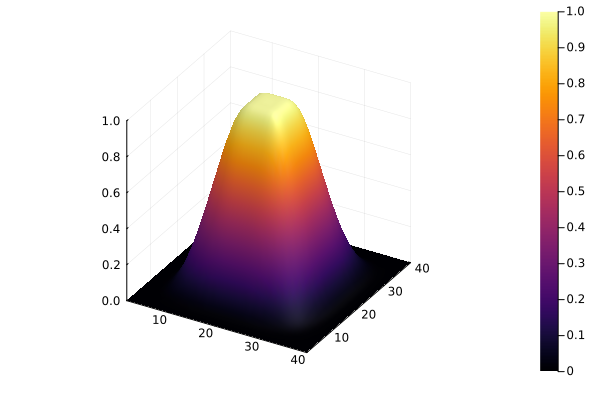

In [9]:
surface(test[:,:,1,1])

In [10]:
dummy_data = gen_random_field(fine_mesh.N,10, samples = (1,20))

200×200×1×20 Array{Float64, 4}:
[:, :, 1, 1] =
  0.0527003   0.254474     0.430296    …  -0.591388   -0.383307   -0.164083
  0.157778    0.377929     0.572288       -0.537823   -0.313383   -0.0769292
  0.262601    0.496075     0.703888       -0.472465   -0.234879    0.0146967
  0.364494    0.605286     0.820552       -0.394988   -0.148481    0.109103
  0.461128    0.702424     0.91838        -0.305015   -0.0547596   0.204818
  0.550592    0.784978     0.994316    …  -0.202254    0.0457662   0.30059
  0.631431    0.851171     1.04631        -0.0866725   0.152532    0.395362
  0.702651    0.900008     1.07342         0.0413386   0.26482     0.488226
  0.76369     0.931281     1.07584         0.1808      0.381646    0.578345
  0.814358    0.945528     1.05488         0.330022    0.501664    0.664889
  0.854761    0.943941     1.01284     …   0.486522    0.623094    0.746956
  0.885213    0.928247     0.952871        0.647012    0.743691    0.823518
  0.906147    0.90056      0.878774     

In [19]:

function carry_out_local_SVD_overlap_2D_periodic_only(input,MP)

    UPC = MP.fine_mesh.UPC
    dims = MP.fine_mesh.dims
    
    overlap_fine_mesh = MP.fine_mesh
    overlap_coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh, 2 .* MP.J)
    overlap_MP = gen_mesh_pair(overlap_fine_mesh,overlap_coarse_mesh)
    
    kernel_x= collect(LinRange(-1,1,overlap_MP.J[1]+1))
    kernel_y = collect(LinRange(-1,1,overlap_MP.J[2]+1))

    kernel_mesh = gen_mesh(kernel_x,kernel_y,UPC = UPC,use_GPU = false)
    kernel = kernel_mesh.eval_function(mollifier_bump_kernel)
    #bilinear_kernel
    #kernel = kernel_mesh.eval_function(bilinear_kernel)
    reshaped_input_1 = kernel .* reshape_for_local_SVD(input,overlap_MP,subtract_average = false)
    reshaped_input_2 = kernel .* reshape_for_local_SVD(circshift(input,MP.J),overlap_MP,subtract_average = false)

    #reshaped_input_1 = reshape_for_local_SVD(input,overlap_MP,subtract_average = false)
    #reshaped_input_2 = reshape_for_local_SVD(circshift(input,MP.J),overlap_MP,subtract_average = false)

    
    reshaped_input = cat(reshaped_input_1,reshaped_input_2,dims = dims+2)
    vector_input = reshape(reshaped_input,(prod(size(reshaped_input)[1:end-1]),size(reshaped_input)[end]))

    SVD = svd(vector_input)

    return  reshape(SVD.U,(overlap_MP.J...,UPC,Int(size(SVD.U)[end]))),SVD.S,overlap_MP
end
    

carry_out_local_SVD_overlap_2D_periodic_only (generic function with 1 method)

In [20]:

modes,S = carry_out_local_SVD(dummy_data,MP)
overlap_modes,overlap_S,overlap_MP = carry_out_local_SVD_overlap_2D_periodic_only(dummy_data,MP)

([3.2959746043559335e-17 -1.3411763675100778e-13 … 8.60861343537551e-15 2.062533494495023e-19; -1.2563561302414428e-13 -2.0234907219096112e-7 … -1.1466208346812218e-7 6.070549624456235e-15; … ; 4.577526598066626e-14 -6.916502000630131e-8 … -2.1861003466662834e-7 -1.5311150656770705e-13; 2.4033673995989176e-19 5.787776731466957e-14 … -1.3549003305131291e-13 -1.4410659579810653e-20;;;; -1.1102230246251565e-16 -3.6073326917788963e-12 … -5.873314723252834e-13 -5.160558495778926e-19; -3.569755602228497e-12 -2.9290509156426083e-6 … -2.836734865072354e-7 -1.73742005910858e-13; … ; 5.990496233335606e-14 2.1030214773794323e-7 … 2.8004697767154466e-6 3.4110998281014105e-12; 3.2874670852855563e-19 4.69597582003075e-13 … 3.407478231254627e-12 4.048674407078286e-18;;;; 8.673617379884035e-19 -1.4106742529958776e-13 … -3.1646870488734473e-12 -3.7194338669609934e-18; 2.1421482209599274e-13 5.8106640976712854e-8 … -2.6490589875414495e-6 -3.2056176970468987e-12; … ; 3.6161538939018823e-12 2.956382600375

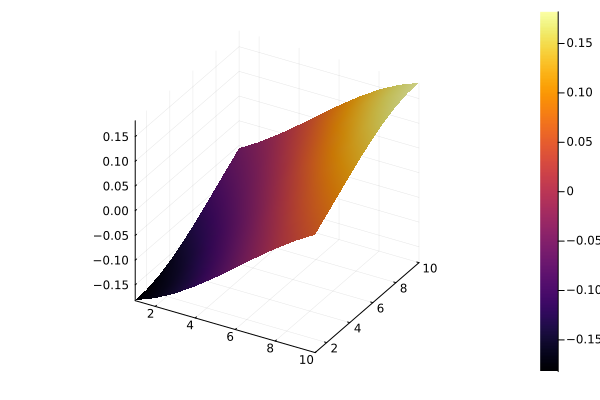

In [39]:
surface(modes[:,:,1,3])

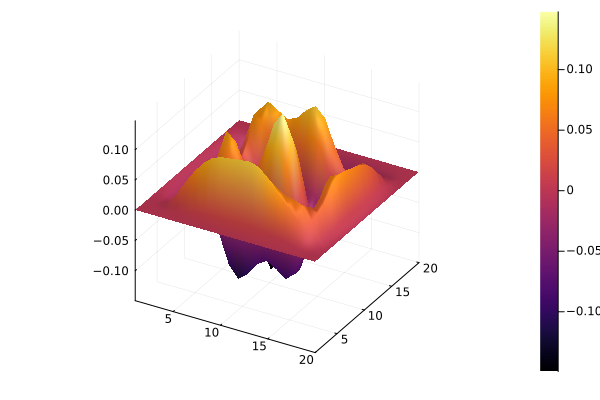

In [45]:
surface(overlap_modes[:,:,1,20])

In [23]:
function local_to_global_modes_overlap_2D_periodic_only(overlap_modes,overlap_MP)
    overlap_global_modes = local_to_global_modes(overlap_modes,overlap_MP)

    shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))
    
    shifted_x = circshift( overlap_global_modes,(shift_x,0))
    shifted_y = circshift( overlap_global_modes,(0,shift_y))
    
    shifted_x_y = circshift( overlap_global_modes,(shift_x,shift_y))
    dims = overlap_MP.fine_mesh.dims
    modes = cat(overlap_global_modes,shifted_x,shifted_y,shifted_x_y,dims = dims +2)
    indexes = collect(1:size(overlap_global_modes)[end])
    shifted_indexes_x = indexes .+ size(overlap_global_modes)[end]
    shifted_indexes_y = indexes .+ 2*size(overlap_global_modes)[end]
    shifted_indexes_x_y = indexes .+ 3*size(overlap_global_modes)[end]

    indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    return modes[:,:,:,indexes]
end

r = 10
global_modes = local_to_global_modes(modes[:,:,:,1:r],MP)
overlap_global_modes = local_to_global_modes_overlap_2D_periodic_only(overlap_modes[:,:,:,1:r],overlap_MP)

200×200×1×40 Array{Float64, 4}:
[:, :, 1, 1] =
  3.29597e-17  -1.34118e-13  -4.34901e-12  …   8.60861e-15   2.06253e-19
 -1.25636e-13  -2.02349e-7   -5.14661e-6      -1.14662e-7    6.07055e-15
 -4.04443e-12  -5.02035e-6   -0.000116442     -3.89493e-6   -2.32821e-12
 -1.99413e-11  -2.227e-5     -0.000492307     -1.96863e-5   -1.58847e-11
 -5.02876e-11  -5.30921e-5   -0.00114048      -5.05804e-5   -4.59936e-11
 -9.23128e-11  -9.42531e-5   -0.0019881    …  -9.4463e-5    -9.15485e-11
 -1.40372e-10  -0.000140384  -0.00292672      -0.000146185  -1.47255e-10
 -1.83438e-10  -0.000181191  -0.00375073      -0.000194685  -2.01042e-10
 -2.06817e-10  -0.00020301   -0.00418762      -0.000224202  -2.35281e-10
 -2.11677e-10  -0.000207559  -0.00427976      -0.000235158  -2.49227e-10
 -2.07904e-10  -0.000204666  -0.0042313    …  -0.000237793  -2.53256e-10
 -1.95677e-10  -0.000194464  -0.00404442      -0.000231952  -2.47132e-10
 -1.66408e-10  -0.000168117  -0.00353151      -0.000206443  -2.19025e-10
  ⋮ 

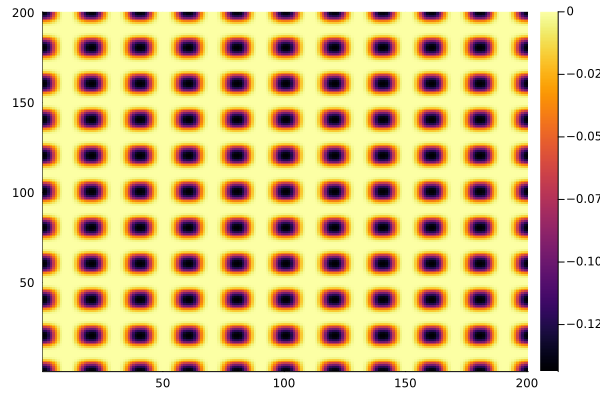

In [34]:
heatmap(overlap_global_modes[:,:,1,4])

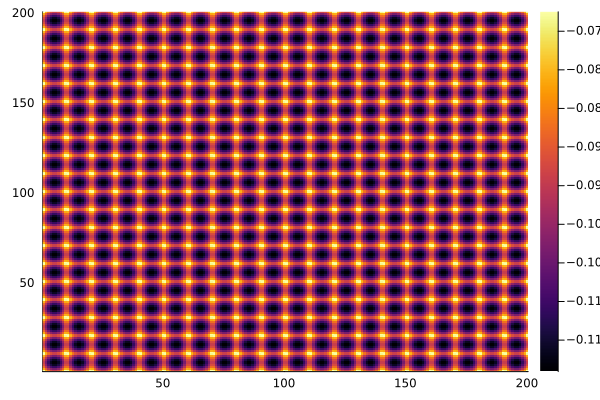

In [31]:
heatmap(global_modes[:,:,1,1])

# Generating POD operators

In [35]:
r = 10

10

In [36]:
PO = gen_projection_operators(modes[:,:,:,1:r],MP)
PO = gen_projection_operators(overlap_modes[:,:,:,1:r],overlap_MP)

local_POD_overlap.module_2D.projection_operators_struct(Conv((20, 20), 1 => 10, stride=20, bias=false), ConvTranspose((20, 20), 10 => 1, stride=20, bias=false))